## Ensemble Learning
Implementing Ensemble learning using XGBoost, Linear Regression, Elastic Net, and Lasso on the "Video Game Sales" dataset from the Kaggle website using different metrics https://www.kaggle.com/datasets/gregorut/videogamesales/data.

## Analysing XGBoost on the dataset:

### Loading The Data and The Necessary Libraries:

In [1]:
# Things that will be used in both parts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

data = pd.read_csv('vgsales.csv')

### Basic EDA and Basic Feature Engineering:

In [3]:
# preprocess the data for both parts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
data.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [5]:
data.dropna(inplace=True)
data.isna().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [20]:
categorical_features = ['Name', 'Platform', 'Genre', 'Publisher']

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ce.TargetEncoder(cols=categorical_features), categorical_features),
        ('num', StandardScaler(), [col for col in X.columns if col not in categorical_features])
    ])

In [7]:
# Split data into features and target, I am choosing the global sales as the label feature
X = data.drop('Global_Sales', axis=1)
y = data['Global_Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

### Initialize The Pipeline:

In [8]:
# Define XGBoost model with adjustable parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 10,
    'learning_rate': 0.1,
    'max_depth': 4,
    'subsample': 0.8
}
xgb_model = xgb.XGBRegressor(**xgb_params)

In [22]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

### Basic CV:

In [9]:
# Define cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

In [27]:
# Define grid search for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4, 5],
    'regressor__subsample': [0.7, 0.8]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         TargetEncoder(cols=['Name',
                                                                                             'Platform',
                                                                                             'Genre',
                                                                                             'Publisher']),
                                                                         ['Name',
                                                                          'Platform',
                                                                          'Genre',
                                                                          'Publisher']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Rank',
                                                                          'Year',
                                                                          'NA_Sales',
                                                                          'EU_Sales',
                                                                          'JP_Sales',
                                                                          'Other_Sales'])])),
                                       ('regressor...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=10,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__n_estimators': [100],
                         'regressor__subsample': [0.7, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [65]:
# Best parameters and model evaluation
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print('------')

# Cross-validation performance
cv_results = grid_search.cv_results_
#print(f"Mean cross-validated results: {cv_results}")
mean_rmse = -grid_search.best_score_
print(f"Mean cross-validated RMSE: {mean_rmse:.4f}")

Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 100, 'regressor__subsample': 0.7}
------
Mean cross-validated RMSE: 0.2466


In [82]:
# Fit the best model on the training dataset
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_xgb = best_model.predict(X_test)
test_rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {test_rmse_xgb:.4f}")

Test RMSE: 0.1381


/home/turhantas/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Basic EDA Again:

In [60]:
# Feature importance
# Extract the trained XGBoost model
xgb_model = best_model.named_steps['regressor']

# Retrieve the feature names from the preprocessor
feature_names = data.columns.tolist()

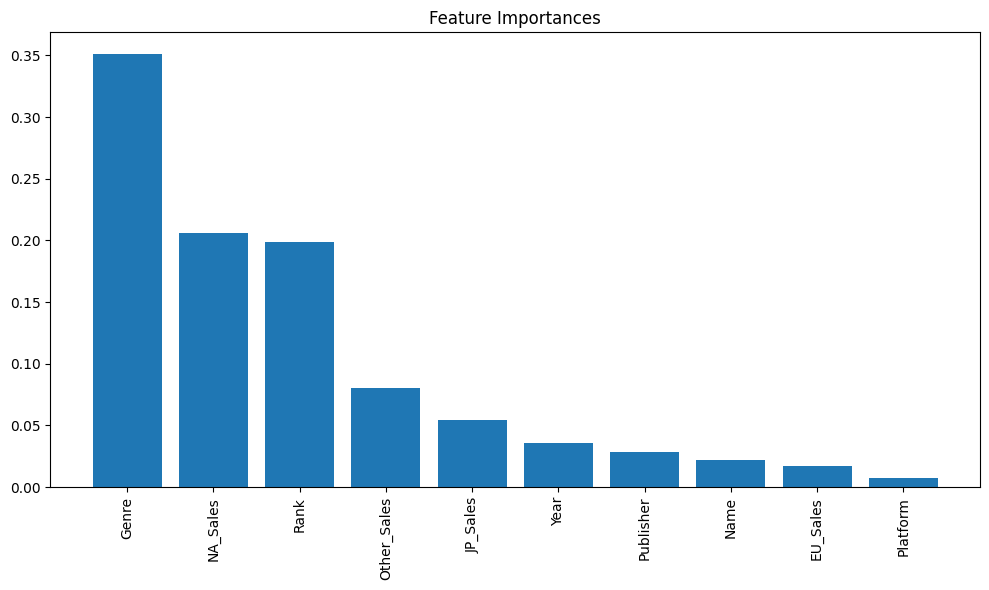

In [61]:
# Plot feature importances
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Cross-Validation and Hyperparameter Tuning
#### Model Performance:
We were able to thoroughly assess our model and determine the ideal hyperparameters by employing cross-validation. We arrived at these ideal settings through the process of fine-tuning:

* Learning Rate: 0.05
* Max Depth: 4
* Number of Estimators: 100
* Subsample: 0.7

The model produced a mean cross-validated RMSE of 0.2466 with these parameters. This suggests a robust and steady performance over various subsets of our data. The model fared considerably better when we ran it on a different test set, obtaining an RMSE of 0.1381. This demonstrates that our model is both well-tuned and has good generalisation to new, untested data.

#### Cross-Validation Benefits:
In our procedure, the cross-validation method—more especially, the use of GridSearchCV with KFold—was essential. Here's how each element was helpful:

##### Grid Search:

* Systematic Hyperparameter Tuning: We were able to systematically investigate different hyperparameter combinations by using grid search. We made sure that the chosen parameters were the best across several data splits, not just one train-test split, by performing this within a cross-validation framework.
* Thorough Evaluation: It assessed every combination at every fold, offering a reliable method for determining the ideal hyperparameters. Finding a model configuration that effectively generalises to new data is made easier by this thoroughness.

##### KFold Cross-Validation:

* Robustness and Stability: KFTraditional cross-validation partitions the data into k folds, or subsets. The process is repeated k times, with the model being trained on k-1 folds and validated on the remaining fold. This guarantees that each and every data point is used for training and validation, offering a thorough evaluation of the model's performance.
* Prevents Overfitting: We lessen the possibility of the model becoming overfit to a certain group of data by testing it on several folds. This implies that in addition to the dataset it was trained on, the model is likely to perform well on other datasets as well.
* Performance Consistency: Our model demonstrated constant performance over multiple folds, with a mean cross-validated RMSE of 0.2466, suggesting its reliability in a range of circumstances. Knowing this consistency is essential to appreciating the stability of the model.

### Feature Importance Analysis
#### Key Insights:
Some intriguing information about the variables influencing the model's predictions may be found in the feature importance plot.

1. Genre:
* The game's genre is by far the most significant predictor. This makes sense because different genres have varied degrees of popularity and appeal to diverse audiences.

2. NA_Sales:
* In North America, sales data are critical. The market conditions and consumer preferences in this area have a big impact on a game's overall performance.

3. Rank:
* The game's ranking has a significant impact as well. Games with higher rankings probably gain more recognition and attention, which improves their performance all around.

4. Other_Sales:
* Outside of North America, Europe, and Japan, sales are also significant. These areas work together to make a game successful worldwide.

5. JP_Sales:
* Sales to Japan are still another significant component. Video game sales are big in Japan, and performance can be greatly impacted by success there.

6. Year:
* Release year makes a big difference. Over time, trends and technical developments may have an impact on a game's popularity.

7. Publisher:
* There is some influence from the game's publisher. Well-known publishers may have more effective marketing plans and access to funding, which helps a game succeed.

8. Name:
* It's interesting to note that the game's name has some influence, albeit a minor one. This might have to do with how well-known a brand is or how appealing particular titles are.

7. EU_Sales:
* Even though they have less of an impact than sales in North America or Japan, sales in Europe do influence the model's forecasts.

8. Platform:
* Among the top features, the platform a game is released on has the least impact, indicating that other aspects are more important in influencing a game's success.

### Conclusion:
With its precisely adjusted hyperparameters, our XGBoost model has proven to be quite stable and performs well. An examination of feature importance provides insight into the key elements that propel video game success. Comprehending these crucial attributes facilitates our comprehension of the intricacies of the industry and can steer forthcoming determinations about game creation and promotion. We are confident that our model will perform well on fresh data because it is both robust and generalizable thanks to the usage of GridSearchCV with KFold cross-validation.

## Stacking:

### Initialize The Pipeline:

In [75]:
# Define the base learners
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.7
}
xgb_model = xgb.XGBRegressor(**xgb_params)
elasticnet_reg = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=12345)
lasso_reg = Lasso(alpha =0.0005, random_state=12345)

# Create a pipeline for the base learners
base_learners = [
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_model)])),
    ('elasticnet_reg', Pipeline(steps=[('preprocessor', preprocessor), ('regressor', elasticnet_reg)])),
    ('lasso_reg', Pipeline(steps=[('preprocessor', preprocessor), ('regressor', lasso_reg)]))
]

# Define the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearRegression()
)

In [76]:
# Fit the stacking model
stacking_regressor.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = stacking_regressor.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Stacking Model Test RMSE: {test_rmse:.4f}")

Stacking Model Test RMSE: 0.0052


/home/turhantas/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Compare Stacked Model and XGBoost only model:

In [81]:
print(f"Stacking Model Test RMSE: {test_rmse:.4f}")
print(f"XGBoost Model Test RMSE: {test_rmse_xgb:.4f}")

Stacking Model Test RMSE: 0.0052
XGBoost Model Test RMSE: 0.1381


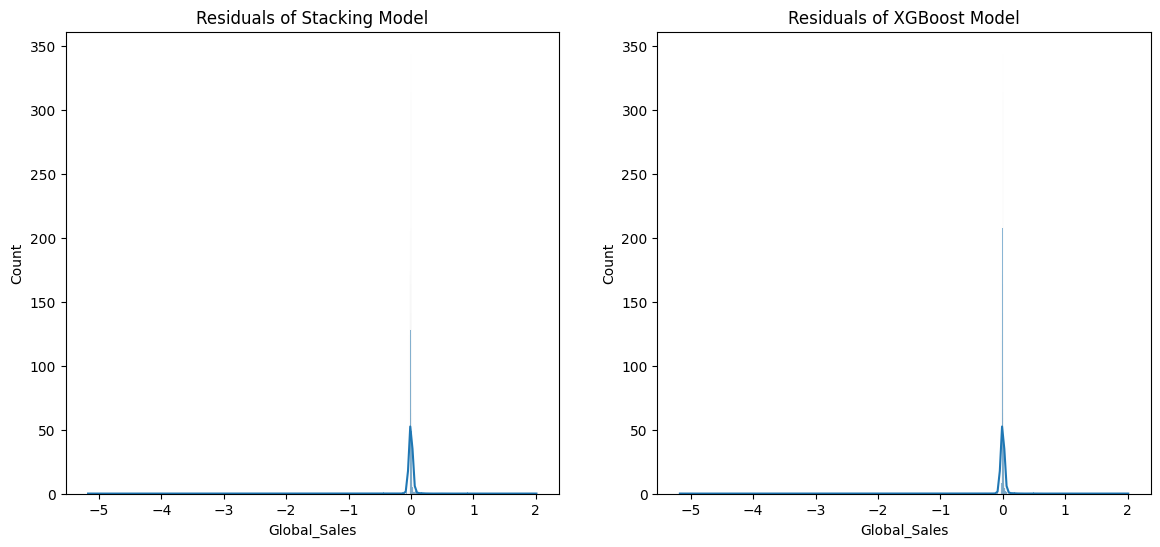

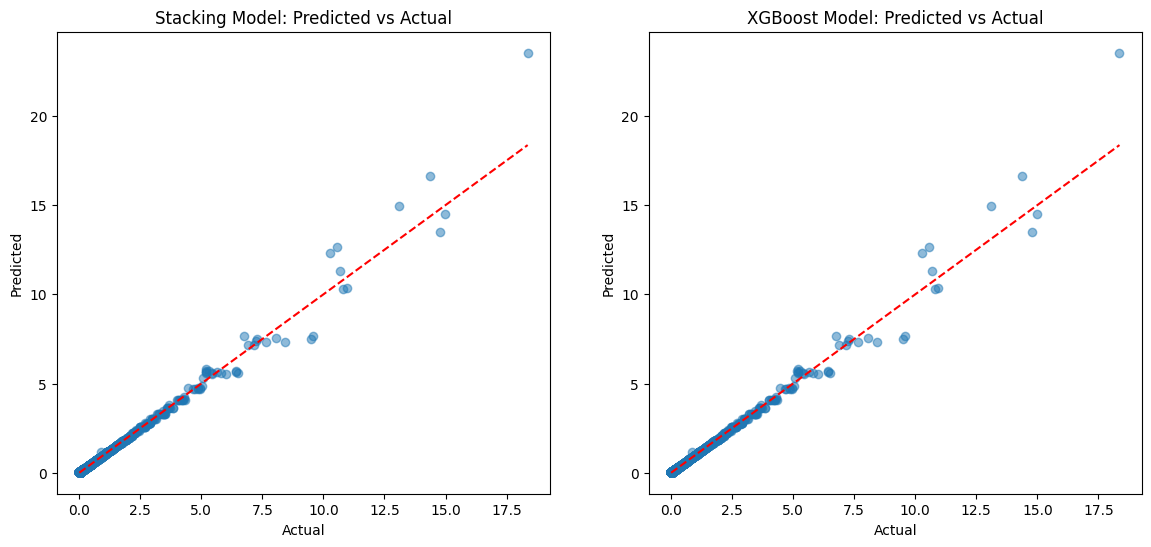

In [84]:
# Residuals
residuals_stacking = y_test - y_pred
residuals_xgb = y_test - y_pred_xgb

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals_stacking, kde=True)
plt.title('Residuals of Stacking Model')

plt.subplot(1, 2, 2)
sns.histplot(residuals_xgb, kde=True)
plt.title('Residuals of XGBoost Model')

plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('Stacking Model: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title('XGBoost Model: Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

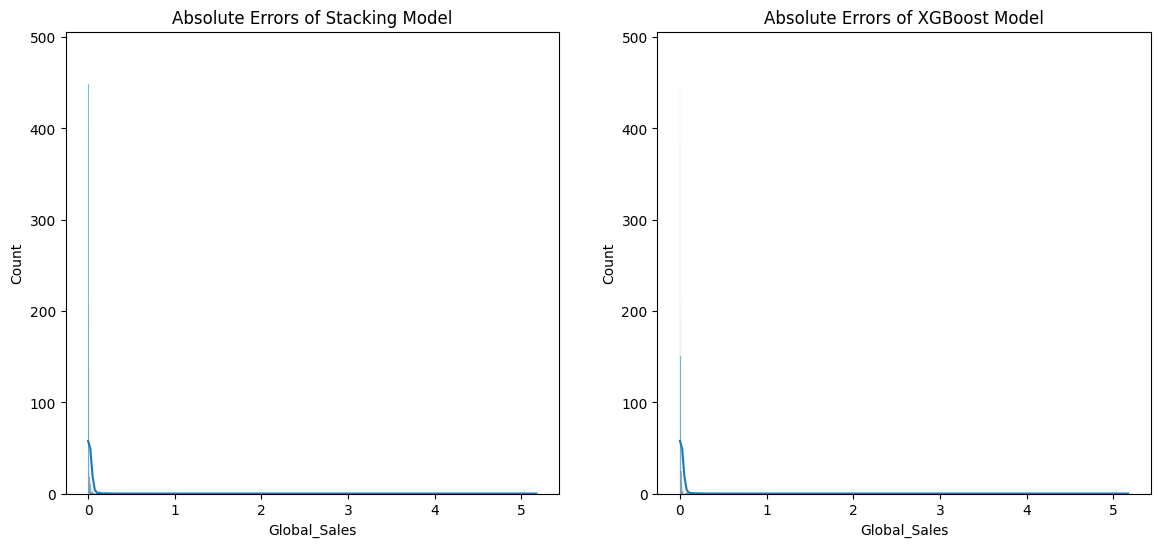

In [86]:
# Calculate absolute errors
abs_errors_stacking = abs(y_test - y_pred)
abs_errors_xgb = abs(y_test - y_pred_xgb)

# Plot the distribution of absolute errors
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(abs_errors_stacking, kde=True)
plt.title('Absolute Errors of Stacking Model')

plt.subplot(1, 2, 2)
sns.histplot(abs_errors_xgb, kde=True)
plt.title('Absolute Errors of XGBoost Model')

plt.show()